# **AMAZAVR SUPPLIER MANAGEMENT: EXPLORATORY DATA ANALYSIS**

<span style="font-size: 20px;">Created by *Oleksiy Danilin (Masterschool)*</span>

<span style="font-size: 16px;">In this book, we conduct a general analysis of the dataset to gain deeper insights into the performance of suppliers within the broader context of the business. We examine the dataset’s structure, explore the relationships between variables through descriptive statistics, and generate new key performance indicators (KPIs) to better track and evaluate sales trends.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## 1. General View of the Dataset

In [ ]:
df = pd.read_csv('amazavr_inventory.csv')

In [ ]:
df.head()

,Unnamed: 0,Product ID,Product Name,Category,Supplier,Month,Unit Price,Stock Quantity,Monthly Sales,Monthly Revenue,Discount %,Reorder Level,Shelf Life (Days),Storage Cost per Unit,Supplier Dependency,Units Defective
0,0,P00071,Kitchen Utensils,Home Goods,GreenLife,01-03-2023,170.37,31,20,3407.4,0.0,29,667,11.31,15,0
1,1,P00071,Kitchen Utensils,Home Goods,GreenLife,01-04-2023,170.37,31,20,3407.4,0.0,29,667,11.31,15,0
2,2,P00071,Kitchen Utensils,Home Goods,GreenLife,01-05-2023,170.37,31,20,3407.4,0.0,29,667,11.31,15,0
3,3,P00071,Kitchen Utensils,Home Goods,GreenLife,01-06-2023,170.37,31,20,3407.4,0.0,29,667,11.31,15,0
4,4,P00071,Kitchen Utensils,Home Goods,GreenLife,01-07-2023,170.37,31,20,3407.4,0.0,29,667,11.31,15,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525120 entries, 0 to 525119
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             525120 non-null  int64  
 1   Product ID             525120 non-null  object 
 2   Product Name           525120 non-null  object 
 3   Category               525120 non-null  object 
 4   Supplier               525120 non-null  object 
 5   Month                  525120 non-null  object 
 6   Unit Price             522495 non-null  float64
 7   Stock Quantity         525120 non-null  int64  
 8   Monthly Sales          525120 non-null  int64  
 9   Monthly Revenue        525120 non-null  float64
 10  Discount %             525120 non-null  float64
 11  Reorder Level          525120 non-null  int64  
 12  Shelf Life (Days)      525120 non-null  int64  
 13  Storage Cost per Unit  525120 non-null  float64
 14  Supplier Dependency    525120 non-nu

In [ ]:
df.isnull().sum()

Unnamed: 0                  0
Product ID                  0
Product Name                0
Category                    0
Supplier                    0
Month                       0
Unit Price               2625
Stock Quantity              0
Monthly Sales               0
Monthly Revenue             0
Discount %                  0
Reorder Level               0
Shelf Life (Days)           0
Storage Cost per Unit       0
Supplier Dependency         0
Units Defective             0
dtype: int64

In [ ]:
# Calculate the number of nulls in 'Unit Price' per Category
nulls_by_category = df.groupby('Category')['Unit Price'].apply(lambda x: x.isnull().sum())

# Calculate the total number of data points per category
total_by_category = df['Category'].value_counts()

# Calculate the share of nulls within each category
share_nulls_by_category = (nulls_by_category / total_by_category) * 100

# Combine the results into a single DataFrame
nulls_table = pd.DataFrame({
    'Number of Nulls': nulls_by_category,
    'Total Data Points': total_by_category,
    'Share of Nulls (%)': share_nulls_by_category
}).reset_index().rename(columns={'index': 'Category'})

# Display the table
print(nulls_table)

      Category  Number of Nulls  Total Data Points  Share of Nulls (%)
0       Beauty              459              87420            0.525051
1     Clothing              396              86900            0.455696
2  Electronics              709             146500            0.483959
3   Home Goods              601             118060            0.509063
4       Sports              460              86240            0.533395


<span style="font-size: 16px;"> An insignificant number of null values, accounting for just 0.5% of the total unit price data points, is present in the 'Unit Price' column. While this represents a minimal distortion, the nulls can be efficiently addressed by imputing values derived from the division of monthly revenue by monthly sales.

In [ ]:
# Impute missing values in the 'Unit Price' column
df['Unit Price'] = df['Unit Price'].fillna(df['Monthly Revenue'] / df['Monthly Sales'])

# Check if there are any remaining null values
print(df['Unit Price'].isnull().sum())

0


<span style="font-size: 16px;"> The unnamed first column (an automatic pandas index) does not provide unique information. The actual uniqueness is already captured in the 'Product ID' column. Since the unnamed index column does not add value, it is better to drop it, resulting in a cleaner CSV dataset.

In [ ]:
# Assign the cleaned data to a new variable
df_cleaned = df.copy()

# Save the cleaned dataset
df_cleaned.to_csv('cleaned_amazavr_data.csv', index=False)

# Reassign cleaned data to df
df = df_cleaned

## 2. Top-down revenue analysis: Unusually uniform time series and breakdown patterns

In [ ]:
# Reassign cleaned data to df
df = df_cleaned

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Correctly parse the 'month' column to the proper datetime format
df['month'] = pd.to_datetime(df['month'], errors='coerce')  # Automatically detects the format and handles inconsistent formats

# Drop rows where parsing failed (if any)
df = df.dropna(subset=['month'])

# Sort the data chronologically (from 2023 to 2024)
df = df.sort_values(by='month')

# Group by 'month' and 'category' to sum the monthly revenue
monthly_revenue_by_category = df.groupby(['month', 'category'])['monthly_revenue'].sum().reset_index()

# Pivot the data to the desired format
pivot_table = monthly_revenue_by_category.pivot_table(index='category', columns='month', values='monthly_revenue', aggfunc='sum')

# Convert the revenue values to millions for readability (divide by 1,000,000)
pivot_table = pivot_table / 1_000_000

# Add a Grand Total column by summing the rows
pivot_table['grand_total'] = pivot_table.sum(axis=1)

# Reorder the columns (excluding 'Grand Total') to show the chronological order from 2023 to 2024
pivot_table = pivot_table[sorted(pivot_table.columns[:-1], key=lambda x: pd.to_datetime(x)) + ['grand_total']]

# Print the final table
print(pivot_table)

month        2023-01-03 00:00:00  2023-01-04 00:00:00  2023-01-05 00:00:00  \
category                                                                     
Beauty                643.063527           643.063527           643.063527   
Clothing              177.416452           177.416452           177.416452   
Electronics           170.692871           170.692871           170.692871   
Home Goods             93.497866            93.497866            93.497866   
Sports                280.756790           280.756790           280.756790   

month        2023-01-06 00:00:00  2023-01-07 00:00:00  2023-01-08 00:00:00  \
category                                                                     
Beauty                643.063527           643.063527           643.063527   
Clothing              177.416452           177.416452           177.416452   
Electronics           170.692871           170.692871           170.692871   
Home Goods             93.497866            93.497866          

<span style="font-size: 16px;"> The monthly revenue structure looks untypically uniform, keeping the same values from month to month. However, we assume that the data are correct and continue working with them.

In [ ]:
# Reassign cleaned data to df
df = df_cleaned

# Standardize column names to avoid formatting issues
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Correctly parse the 'month' column to the proper datetime format
df['month'] = pd.to_datetime(df['month'], errors='coerce')  # Automatically detects the format and handles inconsistent formats

# Drop rows where parsing failed (if any)
df = df.dropna(subset=['month'])

# Sort the data chronologically (from 2023 to 2024)
df = df.sort_values(by='month')

# Group by 'month' and 'supplier' to sum the monthly revenue
monthly_revenue_by_supplier = df.groupby(['month', 'supplier'])['monthly_revenue'].sum().reset_index()

# Pivot the data to the desired format
pivot_table_supplier = monthly_revenue_by_supplier.pivot_table(index='supplier', columns='month', values='monthly_revenue', aggfunc='sum')

# Convert the revenue values to millions for readability (divide by 1,000,000)
pivot_table_supplier = pivot_table_supplier / 1_000_000

# Add a Grand Total column by summing the rows
pivot_table_supplier['grand_total'] = pivot_table_supplier.sum(axis=1)

# Reorder the columns (excluding 'Grand Total') to show the chronological order from 2023 to 2024
pivot_table_supplier = pivot_table_supplier[sorted(pivot_table_supplier.columns[:-1], key=lambda x: pd.to_datetime(x)) + ['grand_total']]

# Step 9: Print the final table
print(pivot_table_supplier)

month           2023-01-03 00:00:00  2023-01-04 00:00:00  2023-01-05 00:00:00  \
supplier                                                                        
BeautyWorld              209.147283           209.147283           209.147283   
ComfortLiving             60.199321            60.199321            60.199321   
FashionPro                33.558375            33.558375            33.558375   
Glamour Supply           160.937029           160.937029           160.937029   
GlobalFit                129.787004           129.787004           129.787004   
GreenLife                181.164768           181.164768           181.164768   
HomeEssentials            30.240077            30.240077            30.240077   
MegaTech                  28.004131            28.004131            28.004131   
PlayWell                 116.923332           116.923332           116.923332   
SportsX                   93.129377            93.129377            93.129377   
StitchStyle              193

<span style="font-size: 16px;"> The same structure uniformity applies to the breakdown of revenue by supplier. Nevertheless, we assume that the data are correct and continue working with them. Below we won't be applying any monthly/quarterly/annual time series analysis, treating the whole dataset as stable and uniform. It is also necessary to note that such a uniformity will definitely affect machine learning efforts, as the model will learn the patterns perfectly.

In [ ]:
# Reassign cleaned data to df
df = df_cleaned

# Standardize column names to avoid formatting issues
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check if Monthly Revenue is the product of Unit Price and Monthly Sales
df['revenue_check'] = df['unit_price'] * df['monthly_sales']

# Apply rounding for better comparison (round to 2 decimal places)
df['revenue_check_rounded'] = df['revenue_check'].round(2)
df['monthly_revenue_rounded'] = df['monthly_revenue'].round(2)

# Identify discrepancies (considering rounding)
discrepancies = df[df['monthly_revenue_rounded'] != df['revenue_check_rounded']]

# Output discrepancies
if discrepancies.empty:
    print("No discrepancies found.")
else:
    print(f"Discrepancies found in {len(discrepancies)} rows:")
    print(discrepancies[['product_id', 'unit_price', 'monthly_sales', 'monthly_revenue', 'revenue_check', 'revenue_check_rounded', 'monthly_revenue_rounded']].head())

No discrepancies found.


<span style="font-size: 16px;"> As the check above shows, in all instances the monthly revenue is the product of unit price and monthly sales. It means that we don't need to apply discount rates to adjust monthly revenue.

## 3. Supplier Analysis

### 3.1. Revenue Structure by Product Category

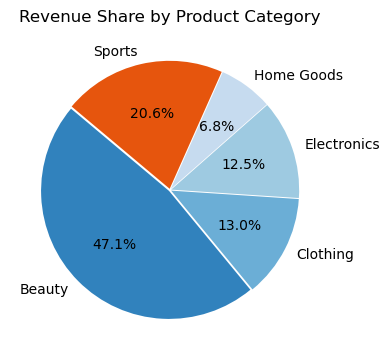

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Calculate total revenue by category
revenue_by_category = df.groupby('category')['monthly_revenue'].sum()

# Calculate percentage shares of total revenue
revenue_shares = (revenue_by_category / revenue_by_category.sum()) * 100

# Plot pie chart
plt.figure(figsize=(4, 4))
colors = plt.cm.tab20c.colors
explode = [0.01] * len(revenue_shares)

plt.pie(revenue_shares, labels=revenue_shares.index, autopct='%1.1f%%', colors=colors, explode=explode, startangle=140)
plt.title('Revenue Share by Product Category', fontsize=12)
plt.tight_layout()
plt.show()

<span style="font-size: 16px;">The beauty product category is the biggest revenue contributor, accounting for almost half of the monthly revenue.

### 3.2. Number of Suppliers and Their Distribution across categories

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Total unique suppliers
total_unique_suppliers = df['supplier'].nunique()

# Distribution of suppliers across product categories
suppliers_per_category = df.groupby('category')['supplier'].nunique()

# Display the results
print(f"Total unique suppliers: {total_unique_suppliers}")
print("\nDistribution of suppliers across product categories:")
print(suppliers_per_category)

Total unique suppliers: 14

Distribution of suppliers across product categories:
category
Beauty         4
Clothing       5
Electronics    6
Home Goods     3
Sports         3
Name: supplier, dtype: int64


In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Group by supplier and count the number of unique categories they work in
supplier_category_counts = df.groupby('supplier')['category'].nunique()

# Filter suppliers working in more than one category
suppliers_in_multiple_categories = supplier_category_counts[supplier_category_counts > 1]

# Get the count of such suppliers
num_suppliers_multiple_categories = len(suppliers_in_multiple_categories)

# Get the list of suppliers
suppliers_list = suppliers_in_multiple_categories.index.tolist()

# Output the results
print(f"Number of suppliers working in more than one product category: {num_suppliers_multiple_categories}")
print("List of suppliers working in more than one product category:")
for supplier in suppliers_list:
    print(supplier)

Number of suppliers working in more than one product category: 7
List of suppliers working in more than one product category:
BeautyWorld
ComfortLiving
GlobalFit
GreenLife
PlayWell
StitchStyle
TechNova


### 3.3. Revenue Contribution by Supplier

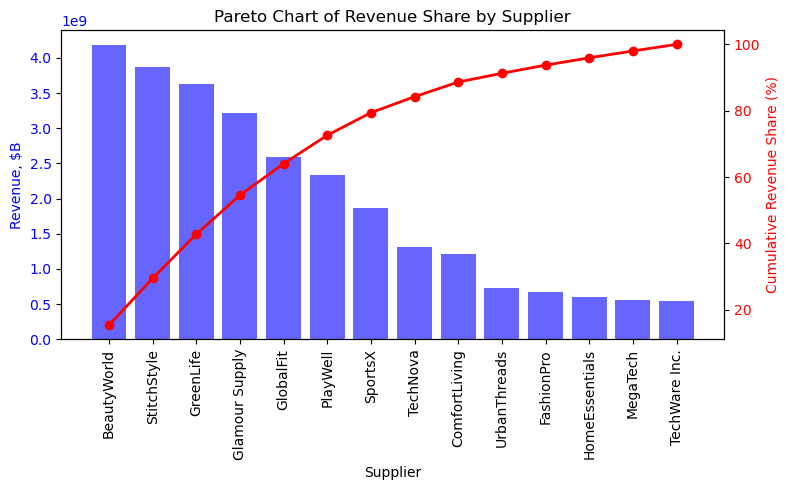

In [ ]:
# Assign the cleaned data to a new variable
df_cleaned = df.copy()

# Save the cleaned dataset
df_cleaned.to_csv('cleaned_amazavr_data.csv', index=False)

# Reassign cleaned data to df
df = df_cleaned

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Calculate total revenue per supplier
supplier_revenue = df.groupby('supplier')['monthly_revenue'].sum().sort_values(ascending=False)

# Calculate cumulative revenue share
cumulative_revenue = supplier_revenue.cumsum() / supplier_revenue.sum() * 100

# Create the Pareto chart
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for individual revenue share
ax1.bar(supplier_revenue.index, supplier_revenue.values, color='b', alpha=0.6, label='Revenue by Supplier')
ax1.set_xlabel('Supplier')
ax1.set_ylabel('Revenue, $B', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for cumulative revenue
ax2 = ax1.twinx()
ax2.plot(supplier_revenue.index, cumulative_revenue, color='r', marker='o', label='Cumulative Revenue Share', linestyle='-', linewidth=2)
ax2.set_ylabel('Cumulative Revenue Share (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and show plot
plt.title('Pareto Chart of Revenue Share by Supplier')

# Set x-axis labels rotation explicitly
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)

# Ensure the layout fits and adjusts properly
fig.tight_layout()

# Show the plot
plt.show()

<span style="font-size: 16px;">BeautyWorld is the biggest revenue contributor, closely followed by StitchStyle and GreenLife. Overall, top five suppliers generate over 60% of the total revenue (monthly, quarterly).

### 3.4. Supplier Revenue Concentration by Product Category (Herfindahl-Hirshman Index, HHI)

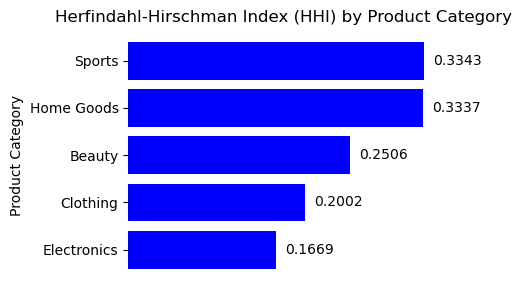

In [ ]:
# Group by category and supplier to calculate total revenue per supplier within each category
category_supplier_revenue = df.groupby(['category', 'supplier'])['monthly_revenue'].sum()

# Calculate total revenue per category
category_total_revenue = category_supplier_revenue.groupby('category').sum()

# Calculate market share per supplier in each category
market_shares = category_supplier_revenue / category_total_revenue

# Calculate HHI for each category (sum of squares of market shares)
hhi_per_category = (market_shares ** 2).groupby('category').sum()

# Normalize HHI to a scale of 0 to 1
hhi_per_category_normalized = hhi_per_category.sort_values(ascending=False)

# Plot as a horizontal bar chart
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.barh(hhi_per_category_normalized.index, hhi_per_category_normalized, color='b')

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', va='center')

# Set plot title and labels
plt.title('Herfindahl-Hirschman Index (HHI) by Product Category')
plt.ylabel('Product Category')

# Invert the y-axis for descending order
plt.gca().invert_yaxis()

# Remove the frame (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove the x-axis and grid lines
ax.xaxis.set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
# Group by category and supplier to calculate total revenue per supplier within each category
category_supplier_revenue = df.groupby(['category', 'supplier'])['monthly_revenue'].sum()

# Calculate total revenue per category
category_total_revenue = category_supplier_revenue.groupby('category').sum()

# Calculate market share per supplier in each category
market_shares = category_supplier_revenue / category_total_revenue

# Calculate HHI for each category (sum of squares of market shares)
hhi_per_category = (market_shares ** 2).groupby('category').sum()

# Rank HHI in descending order by category name
hhi_per_category_sorted = hhi_per_category.sort_index(ascending=False)

# Display sorted HHI
print("HHI per Product Category (Ranked Descending by Category Name):")
print(hhi_per_category_sorted)

HHI per Product Category (Ranked Descending by Category Name):
category
Sports         0.334292
Home Goods     0.333740
Electronics    0.166855
Clothing       0.200245
Beauty         0.250595
Name: monthly_revenue, dtype: float64


<span style="font-size: 16px;">The Supplier Revenue Concentration Index (a variation of HHI) is used here to assess the concentration of revenue contributions among suppliers, leveraging the methodology of the Herfindahl-Hirschman Index (HHI). The SRCI is calculated by summing the squares of the proportional revenue shares of each supplier. The values range from 0 to 1, where:

-- Low (<0.15): Indicates a diverse supplier base with low dependency on individual suppliers.

-- Moderate (0.15–0.25): Reflects a moderately concentrated revenue distribution, with some suppliers contributing more significantly.

-- High (>0.25): Suggests a highly concentrated revenue distribution, where a few suppliers dominate contributions, indicating potential dependency or risk.

1) Sports (0.334292): The revenue contribution is highly concentrated, with a few suppliers contributing a significant portion of revenue. This indicates potential dependency or risk in the supplier base for this category.
2) Home Goods (0.333740): Similar to Sports, the supplier revenue distribution is highly concentrated, suggesting a reliance on a limited number of suppliers.
3) Electronics (0.166855): Displays moderate concentration. While not overly dependent, some suppliers contribute more prominently to revenue.
4) Clothing (0.200245): Reflects moderate concentration, similar to Electronics, though slightly higher in dependency.
5) Beauty (0.250595): On the threshold of high concentration, the supplier base for this category may exhibit increasing dependency or risk.

### 3.5. Strategic Supply Concentration Index (SSCI)

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check if 'monthly_revenue' column exists; ensure no division by zero or invalid rows
if 'monthly_revenue' not in df.columns:
    raise ValueError("The dataset must include a 'monthly_revenue' column to calculate SSCI.")
df = df[df['monthly_revenue'] > 0]

# Calculate total revenue for each supplier
supplier_revenue = (
    df.groupby('supplier')['monthly_revenue']
    .sum()
    .reset_index()
    .rename(columns={'monthly_revenue': 'total_revenue'})
)

# Calculate the number of unique products supplied by each supplier
supplier_products = (
    df.groupby('supplier')['product_id']
    .nunique()
    .reset_index()
    .rename(columns={'product_id': 'num_products_supplied'})
)

# Merge revenue and product count into a single DataFrame
supplier_data = pd.merge(supplier_revenue, supplier_products, on='supplier')

# Calculate SSCI for each supplier
supplier_data['ssci'] = (supplier_data['total_revenue'] / supplier_data['num_products_supplied']).round(2)

# Normalize SSCI to a scale of 0 to 1
ssci_min = supplier_data['ssci'].min()
ssci_max = supplier_data['ssci'].max()
supplier_data['normalized_ssci'] = ((supplier_data['ssci'] - ssci_min) / (ssci_max - ssci_min)).round(2)

# Sort the suppliers by SSCI in descending order
supplier_data = supplier_data.sort_values(by='ssci', ascending=False)

# Format total revenue, num_products_supplied, and SSCI to two decimal places without scientific notation
supplier_data['total_revenue'] = supplier_data['total_revenue'].map('{:.2f}'.format)
supplier_data['num_products_supplied'] = supplier_data['num_products_supplied'].astype(int)  # No decimals needed
supplier_data['ssci'] = supplier_data['ssci'].map('{:.2f}'.format)
supplier_data['normalized_ssci'] = supplier_data['normalized_ssci'].map('{:.2f}'.format)

# Display the results
print("SSCI for Each Supplier (Sorted by SSCI in Descending Order):")
print(supplier_data[['supplier', 'total_revenue', 'num_products_supplied', 'ssci', 'normalized_ssci']])

SSCI for Each Supplier (Sorted by SSCI in Descending Order):
          supplier  total_revenue  num_products_supplied          ssci  \
3   Glamour Supply  3218740586.80                     24  134114191.12   
0      BeautyWorld  4182945661.60                     49   85366237.99   
9          SportsX  1862587530.00                     23   80982066.52   
10     StitchStyle  3868982847.80                     49   78958833.63   
5        GreenLife  3623295366.00                     57   63566585.37   
4        GlobalFit  2597812171.25                     61   42587084.77   
8         PlayWell  2340066895.89                     61   38361752.39   
13    UrbanThreads   721507441.80                     25   28860297.67   
2       FashionPro   671167502.60                     25   26846700.10   
11        TechNova  1315709491.60                     63   20884277.64   
6   HomeEssentials   604801530.00                     33   18327319.09   
1    ComfortLiving  1206397866.85                  

<span style="font-size: 16px;">The Strategic Supply Concentration Index (SSCI) is a metric designed to evaluate the focus of a supplier's contributions in terms of revenue and product diversity. It helps to assess the risk of over-reliance on a supplier that dominates key revenue-generating products. A higher SSCI value indicates that a supplier generates significant revenue from a relatively small number of products, which could increase dependency on them for critical product lines.

1) High SSCI Suppliers (Glamour Supply, SportsX, BeautyWorld): These suppliers warrant closer monitoring and stronger relationships, as they generate significant revenue while focusing on fewer products. Their concentration makes them potential points of vulnerability in the supply chain.
2) Moderate SSCI Suppliers (StitchStyle, GreenLife, GlobalFit): They may be less critical but still important contributors. Diversification in products suggests resilience to specific product disruptions.
3) Low SSCI Suppliers (TechNova, TechWare Inc., etc.): These suppliers are less strategically concentrated and pose minimal risk if disruptions occur. They may also offer flexibility in terms of alternative sourcing.

### 3.6. Supplier Dependency and Discount Policies

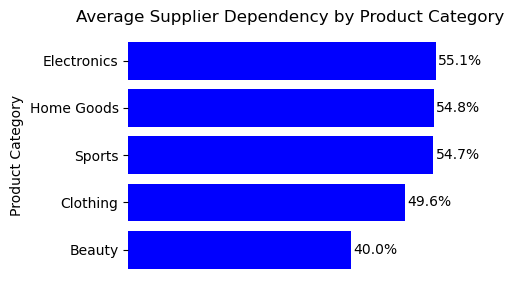

In [ ]:
# Group by category and calculate average supplier dependency per category
category_supplier_dependency = df.groupby('category')['supplier_dependency'].mean()

# Convert supplier dependency values to percentages
category_supplier_dependency_percentage = category_supplier_dependency

# Sort the data in descending order
category_supplier_dependency_percentage = category_supplier_dependency_percentage.sort_values(ascending=False)

# Plot as a horizontal bar chart
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.barh(category_supplier_dependency_percentage.index,
               category_supplier_dependency_percentage, color='b')

# Add labels to each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%', va='center')

# Set plot title and labels
plt.title('Average Supplier Dependency by Product Category')
plt.ylabel('Product Category')

# Invert the y-axis for descending order
plt.gca().invert_yaxis()

# Remove the frame (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove the x-axis and grid lines
ax.xaxis.set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

1) Electronics, Home Goods, and Sports are the three categories with the highest supplier dependency index, which stands roughly at the same level (55%). High dependency suggests that these categories may be vulnerable to disruptions if key suppliers fail to deliver. It also indicates limited diversification in the supply base.
2) Clothing exhibits a lower supplier dependency (around 50%), indicating a more diversified supplier base, which might make the supply chain less prone to significant disruptions.
3) The Beauty category has the lowest supplier dependency suggesting a healthier and more competitive supplier ecosystem. This reduces risks related to over-reliance on a few suppliers. However, even though the Beauty's index is lower than in other product categries, it is still relatiely high.
4) Overall, the whole business suffers from high supplier dependency (average supplier dependency exceeds 50% across the whole product palette).

In [ ]:
# Calculate average supplier dependency per supplier in each category
supplier_dependency_per_category_supplier = df.groupby(['category', 'supplier'])['supplier_dependency'].mean().reset_index()

# Calculate average supplier dependency per category
avg_dependency_per_category = supplier_dependency_per_category_supplier.groupby('category')['supplier_dependency'].mean().reset_index()

# Rename column for clarity
avg_dependency_per_category.rename(columns={'supplier_dependency': 'Average Supplier Dependency (%)'}, inplace=True)

# Print tables
print("Extended Table: Average Supplier Dependency by Product Category")
print(avg_dependency_per_category)

print("\nExtended Table: Supplier Dependency by Category and Supplier")
print(supplier_dependency_per_category_supplier)

Extended Table: Average Supplier Dependency by Product Category
      category  Average Supplier Dependency (%)
0       Beauty                        39.940595
1     Clothing                        49.274540
2  Electronics                        54.770842
3   Home Goods                        54.983624
4       Sports                        54.957572

Extended Table: Supplier Dependency by Category and Supplier
       category        supplier  supplier_dependency
0        Beauty     BeautyWorld            40.402766
1        Beauty  Glamour Supply            39.335545
2        Beauty       GreenLife            39.885057
3        Beauty     StitchStyle            40.139013
4      Clothing     BeautyWorld            40.329268
5      Clothing      FashionPro            40.735290
6      Clothing     StitchStyle            40.096471
7      Clothing        TechNova            85.204900
8      Clothing    UrbanThreads            40.006772
9   Electronics   ComfortLiving            39.656959
10 

<span style="font-size: 16px;">Suppliers with lower dependency are less vulnerable to disruptions, as they have more alternatives in the supply chain. On the other hand, high dependency suppliers may be strategically focused on specific niches or markets but face greater risks from supply chain interruptions.
  
  -- Suppliers like TechNova, PlayWell, and HomeEssentials demonstate VERY HIGH dependency, indicating specialized partnerships or monopolistic supplier relationships within certain categories.
  
  -- Conversely, suppliers such as BeautyWorld and GreenLife have much lower dependency, demonstrating more flexible and diversified supplier relationships.

In [ ]:
# Calculate average supplier dependency per supplier
supplier_dependency_per_supplier = df.groupby('supplier')['supplier_dependency'].mean().reset_index()

# Rename column for clarity
supplier_dependency_per_supplier.rename(columns={'supplier_dependency': 'Average Supplier Dependency (%)'}, inplace=True)

# Calculate average discount rate per supplier
avg_discount_per_supplier = df.groupby('supplier')['discount_%'].mean().reset_index()
avg_discount_per_supplier.rename(columns={'discount_%': 'Average Discount Rate (%)'}, inplace=True)

# Merge supplier-level dependency and discount rates
supplier_dependency_with_discount = supplier_dependency_per_supplier.merge(avg_discount_per_supplier, on='supplier')

# Order the table by Average Supplier Dependency in descending order
supplier_dependency_with_discount = supplier_dependency_with_discount.sort_values(by='Average Supplier Dependency (%)', ascending=False)

# Print extended table
print("Extended Table: Supplier Dependency and Discount Rate by Supplier")
print(supplier_dependency_with_discount)

Extended Table: Supplier Dependency and Discount Rate by Supplier
          supplier  Average Supplier Dependency (%)  Average Discount Rate (%)
8         PlayWell                        85.063438                   5.413243
11        TechNova                        84.978305                   7.476375
6   HomeEssentials                        84.862816                   6.075034
2       FashionPro                        40.735290                   1.338232
7         MegaTech                        40.585415                   1.437168
0      BeautyWorld                        40.370568                   1.543356
10     StitchStyle                        40.120611                   1.557491
1    ComfortLiving                        40.029363                   1.469038
13    UrbanThreads                        40.006772                   1.374594
9          SportsX                        39.925847                   1.421864
5        GreenLife                        39.860457              

<span style="font-size: 16px;">Suppliers with the highest dependency rates feature higher discount rates:

1) TechNova (85.20%) offers 7.64% in Clothing and 7.36% in Electronics.
2) PlayWell (84.85%) in Electronics provides a 5.51% discount rate.
3) HomeEssentials (84.86%) in Home Goods offers a 6.08% discount rate.

<span style="font-size: 16px;">This trend suggests a deliberate strategy where suppliers with high dependency rates use higher discounts to sustain or strengthen relationships with their buyers. The reasoning might include:
  1) Mitigating risks: Suppliers with high dependency might feel compelled to offer competitive pricing to retain long-term commitments from buyers.
  2) Market competition: These suppliers may operate in highly competitive industries and use discounts to maintain their market share.
  3) Dependence pressure: Buyers might demand higher discounts as compensation for their significant reliance on these suppliers.

### 3.7. Supplier Cost Efficiency Analysis

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Check if 'cost' column exists; calculate cost if needed
if 'cost' not in df.columns:
    # Calculate cost using stock_quantity, unit_price, discount_%, and storage_cost_per_unit
    df['cost'] = (df['stock_quantity'] * df['unit_price'] * (1 - df['discount_%'] / 100)) + df['storage_cost_per_unit']

# Ensure no division by zero or invalid rows for monthly_revenue
df = df[df['monthly_revenue'] > 0]

# Calculate profit margin
df['profit_margin'] = ((df['monthly_revenue'] - df['cost']) / df['monthly_revenue']) * 100

# Group by supplier and category to calculate the average profit margin
profit_margin_by_supplier_category = (
    df.groupby(['supplier', 'category'])['profit_margin']
    .mean()
    .reset_index()
)

# Round profit margins to two decimal places
profit_margin_by_supplier_category['profit_margin'] = profit_margin_by_supplier_category['profit_margin'].round(2)

# Format profit margins as percentages
profit_margin_by_supplier_category['profit_margin'] = profit_margin_by_supplier_category['profit_margin'].astype(str) + '%'

# Calculate average profit margin for each category
profit_margin_by_category = (
    df.groupby('category')['profit_margin']
    .mean()
    .reset_index()
)

# Round and format the category-level profit margins
profit_margin_by_category['profit_margin'] = profit_margin_by_category['profit_margin'].round(2)
profit_margin_by_category['profit_margin'] = profit_margin_by_category['profit_margin'].astype(str) + '%'

# Calculate overall average profit margin
overall_avg_profit_margin = df['profit_margin'].mean().round(2)

# Display the results
print("Profit Margin for Each Supplier Across Each Product Category:")
print(profit_margin_by_supplier_category)

print("\nAverage Profit Margin for Each Category:")
print(profit_margin_by_category)

print(f"\nOverall Average Profit Margin: {overall_avg_profit_margin}%")

Profit Margin for Each Supplier Across Each Product Category:
          supplier     category profit_margin
0      BeautyWorld       Beauty         4.27%
1      BeautyWorld     Clothing        30.34%
2    ComfortLiving  Electronics         1.37%
3    ComfortLiving   Home Goods       -61.11%
4       FashionPro     Clothing        30.36%
5   Glamour Supply       Beauty         4.16%
6        GlobalFit  Electronics         1.37%
7        GlobalFit       Sports        35.56%
8        GreenLife       Beauty         4.39%
9        GreenLife   Home Goods       -62.51%
10  HomeEssentials   Home Goods       -51.47%
11        MegaTech  Electronics         1.54%
12        PlayWell  Electronics         3.62%
13        PlayWell       Sports        38.41%
14         SportsX       Sports        35.13%
15     StitchStyle       Beauty         4.27%
16     StitchStyle     Clothing        30.19%
17        TechNova     Clothing        34.75%
18        TechNova  Electronics         9.89%
19   TechWare Inc.

<span style="font-size: 16px;">The overall average profit margin is -0.56%, suggesting that, on the whole, the company is operating at a loss or struggling with profitability, especially due to underperforming categories like Home Goods and Electronics.

-- Beauty: Suppliers in this category (e.g., BeautyWorld, Glamour Supply, GreenLife, and StitchStyle) have relatively low profit margins, ranging from 4.16% to 4.39%.

-- Clothing: Suppliers such as BeautyWorld, FashionPro, StitchStyle, TechNova, and UrbanThreads have strong profit margins, with averages around 30-34%. This category appears highly profitable.

-- Electronics: Suppliers like ComfortLiving, GlobalFit, MegaTech, and PlayWell show relatively low profit margins, ranging from 1.37% to 9.89%. This suggests higher competition or higher costs in this category.

-- Home Goods: This category is underperforming, with negative profit margins (e.g., ComfortLiving, GreenLife, and HomeEssentials), indicating high costs / insufficient sales in this category.

--Sports: PlayWell, GlobalFit, and SportsX show strong profit margins, ranging from 35% to 38%, indicating good profitability in this category.


In [ ]:
# Calculate total storage cost
df['total_storage_cost'] = df['stock_quantity'] * df['storage_cost_per_unit']

# Calculate Storage Cost Ratio (Revenue)
df['storage_cost_ratio_revenue,%'] = (df['total_storage_cost'] / df['monthly_revenue']) * 100

# Group by supplier and category to calculate the average Storage Cost Ratio (Revenue)
storage_cost_ratio_by_supplier_category = (
    df.groupby(['supplier', 'category'])['storage_cost_ratio_revenue,%']
    .mean()
    .reset_index()
)

# Round Storage Cost Ratio (Revenue) to two decimal places
storage_cost_ratio_by_supplier_category['storage_cost_ratio_revenue, %'] = storage_cost_ratio_by_supplier_category['storage_cost_ratio_revenue,%'].round(2)

# Remove the unrounded column
storage_cost_ratio_by_supplier_category.drop(columns=['storage_cost_ratio_revenue,%'], inplace=True)

# Group by category to calculate the average Storage Cost Ratio (Revenue)
storage_cost_ratio_by_category = (
    df.groupby('category')['storage_cost_ratio_revenue,%']
    .mean()
    .reset_index()
)

# Round Storage Cost Ratio (Revenue) to two decimal places
storage_cost_ratio_by_category['storage_cost_ratio_revenue, %'] = storage_cost_ratio_by_category['storage_cost_ratio_revenue,%'].round(2)

# Remove the unrounded column
storage_cost_ratio_by_category.drop(columns=['storage_cost_ratio_revenue,%'], inplace=True)

# Display the results
print("Storage Cost Ratio (Revenue) by Supplier and Category:")
print(storage_cost_ratio_by_supplier_category)

print("\nAverage Storage Cost Ratio (Revenue) by Product Category:")
print(storage_cost_ratio_by_category)

Storage Cost Ratio (Revenue) by Supplier and Category:
          supplier     category  storage_cost_ratio_revenue, %
0      BeautyWorld       Beauty                          15.03
1      BeautyWorld     Clothing                           3.92
2    ComfortLiving  Electronics                           4.59
3    ComfortLiving   Home Goods                          13.31
4       FashionPro     Clothing                           3.78
5   Glamour Supply       Beauty                          15.03
6        GlobalFit  Electronics                           4.29
7        GlobalFit       Sports                           4.71
8        GreenLife       Beauty                          14.92
9        GreenLife   Home Goods                          12.98
10  HomeEssentials   Home Goods                          12.56
11        MegaTech  Electronics                           4.79
12        PlayWell  Electronics                           4.32
13        PlayWell       Sports                           4.79


1) Beauty: The highest average ratio (15.06%), indicating that beauty products are storage-intensive relative to revenue. The company might need to optimize storage costs or increase revenue to improve margins in this category.
2) Home Goods:  The second-highest average ratio (12.95%), reflecting high storage costs, likely due to larger or heavier items requiring more space or specific storage conditions.
3) Clothing, Electronics, Sports: These categories have low ratios (4–5%), suggesting efficient storage operations. Electronics and Sports products are particularly noteworthy for their consistently low ratios across suppliers.

### 3.8. Supplier Product Quality Analysis

In [ ]:
# Calculate defect rate as percentage
df['defect_rate'] = (df['units_defective'] / df['stock_quantity']) * 100

# Round defect rate to 2 decimals for formatting
df['defect_rate'] = df['defect_rate'].round(2)

# Group by supplier and category
defect_rate_by_supplier_category = (
    df.groupby(['supplier', 'category'])
    .agg({'defect_rate': 'mean'})
    .reset_index()
)

# Format defect rate for display as percentage
defect_rate_by_supplier_category['defect_rate'] = defect_rate_by_supplier_category['defect_rate'].apply(lambda x: f"{x:.2f}%")

# Calculate averages across categories
average_defect_rate_by_category = (
    df.groupby('category')
    .agg({'defect_rate': 'mean'})
    .reset_index()
)

# Round averages and format as percentage
average_defect_rate_by_category['defect_rate'] = average_defect_rate_by_category['defect_rate'].round(2)
average_defect_rate_by_category['defect_rate'] = average_defect_rate_by_category['defect_rate'].apply(lambda x: f"{x:.2f}%")

# Display the results
print("Defect Rate by Supplier and Category:")
print(defect_rate_by_supplier_category.to_string(index=False))

print("\nAverage Defect Rate by Category:")
print(average_defect_rate_by_category.to_string(index=False))

Defect Rate by Supplier and Category:
      supplier    category defect_rate
   BeautyWorld      Beauty       6.63%
   BeautyWorld    Clothing      17.75%
 ComfortLiving Electronics       6.41%
 ComfortLiving  Home Goods       0.05%
    FashionPro    Clothing      17.81%
Glamour Supply      Beauty       6.65%
     GlobalFit Electronics       6.09%
     GlobalFit      Sports      10.05%
     GreenLife      Beauty       6.59%
     GreenLife  Home Goods       0.04%
HomeEssentials  Home Goods       0.04%
      MegaTech Electronics       6.08%
      PlayWell Electronics       6.01%
      PlayWell      Sports      10.22%
       SportsX      Sports      10.00%
   StitchStyle      Beauty       6.77%
   StitchStyle    Clothing      17.74%
      TechNova    Clothing      17.94%
      TechNova Electronics       6.26%
 TechWare Inc. Electronics       6.15%
  UrbanThreads    Clothing      17.94%

Average Defect Rate by Category:
   category defect_rate
     Beauty       6.66%
   Clothing      17.84

1) Beauty: Most suppliers (BeautyWorld, Glamour Supply, GreenLife, StitchStyle) have defect rates around the average (6.66%), indicating consistency. However, StitchStyle slightly exceeds this average.
2) Clothing: Suppliers (FashionPro, StitchStyle, TechNova, UrbanThreads) show consistently high defect rates (~17.8%), pointing to quality issues inherent in this category.
3) Electronics: Defect rates are slightly lower than in Beauty, with most suppliers (ComfortLiving, GlobalFit, MegaTech, PlayWell, TechNova, TechWare Inc.) clustering near the category average (6.16%).
4) Home Goods: This category stands out for its extremely low defect rate (0.04%), suggesting strong quality control processes.
5) Sports: Both PlayWell and SportsX report similar defect rates (~10%), which are above the average for categories like Beauty and Electronics.

**Recommendations:**
1) Focus on Clothing suppliers to investigate quality issues and identify root causes of high defect rates.
3) Maintain partnerships with high-performing suppliers in Home Goods and low-defect-rate suppliers in Electronics and Beauty.
4) Explore whether the higher defect rates in Clothing and Sports categories are due to specific supplier practices, product complexity, or other factors.

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Ensure numeric data types
df['monthly_sales'] = pd.to_numeric(df['monthly_sales'], errors='coerce')
df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')
df['defect_rate'] = pd.to_numeric(df['defect_rate'], errors='coerce')  # Assuming defect_rate is given in percentage

# Calculate defect-associated loss for each product
df['defect_associated_loss'] = df['unit_price'] * (df['units_defective'])

# Calculate total revenue for each product
df['total_revenue'] = df['monthly_sales'] * df['unit_price']

# Calculate the ratio of defect-associated loss to total revenue
df['ratio'] = df['defect_associated_loss'] / df['total_revenue']

# Group and summarize data by category
summary = df.groupby(['category']).agg(
    total_monthly_revenue=('total_revenue', 'sum'),
    total_defect_associated_loss=('defect_associated_loss', 'sum'),
    avg_loss_to_revenue_ratio=('ratio', 'mean')
).reset_index()

# Convert total defect associated loss to millions
summary['total_defect_associated_loss, $M'] = (summary['total_defect_associated_loss'] / 1e6).round(2)

# Convert the ratio to percentage and round to 2 decimal places
summary['defect_loss_to_revenue_ratio'] = (summary['avg_loss_to_revenue_ratio']*100).round(2).astype(str) + '%'

# Drop unnecessary columns (total_defect_associated_loss and avg_loss_to_revenue_ratio)
summary = summary.drop(columns=['total_monthly_revenue', 'total_defect_associated_loss', 'avg_loss_to_revenue_ratio'])

# Display the final summary
print(summary)

      category  total_defect_associated_loss, $M defect_loss_to_revenue_ratio
0       Beauty                            825.93                        6.45%
1     Clothing                            438.97                       12.37%
2  Electronics                            149.76                         3.9%
3   Home Goods                              1.03                        0.03%
4       Sports                            363.33                        6.37%


<span style="font-size: 16px;">Total Defect-Associated Loss ($M) is the monetary value of losses attributed to defective products in each category.Higher values indicate a significant impact of defects on the company's finances in that category.

<span style="font-size: 16px;">Defect Loss-to-Revenue Ratio:this percentage indicates the proportion of revenue lost due to defects. Higher ratios suggest a greater financial burden relative to the revenue generated in the category.

1) Beauty has the highest absolute loss among all categories due to high sales volume. The ratio of 6.45% is moderate but suggests that defects significantly impact profitability in this high-revenue category.
2) Clothing has the highest loss-to-revenue ratio, indicating severe quality issues that disproportionately affect its revenue. Even though the total loss is lower than in Beauty, the relative impact on revenue is much greater.
3) Electronics has a relatively low loss-to-revenue ratio, suggesting better quality control compared to other categories. Despite moderate total losses, the ratio indicates that the category performs well financially relative to defects.
4) Home Goods is a standout category with minimal financial losses from defects. The negligible ratio highlights exceptional quality control and low defect rates.
5) Sports is comparable to Beauty in its ratio and absolute loss, reflecting moderate financial strain from defects. It indicates room for improvement but not as critical as Clothing.


In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Ensure numeric data types
df['monthly_sales'] = pd.to_numeric(df['monthly_sales'], errors='coerce')
df['unit_price'] = pd.to_numeric(df['unit_price'], errors='coerce')
df['defect_rate'] = pd.to_numeric(df['defect_rate'], errors='coerce')  # Assuming defect_rate is given in percentage

# Calculate defect-associated loss for each product
df['defect_associated_loss'] = df['unit_price'] * (df['units_defective'])

# Calculate total revenue for each product
df['total_revenue'] = df['monthly_sales'] * df['unit_price']

# Calculate the ratio of defect-associated loss to total revenue
df['ratio'] = df['defect_associated_loss'] / df['total_revenue']

# Group and summarize data by supplier and category
summary = df.groupby(['supplier', 'category']).agg(
    total_defect_associated_loss=('defect_associated_loss', 'sum'),
    avg_loss_to_revenue_ratio=('ratio', 'mean')
).reset_index()

# Convert total defect-associated loss to millions
summary['defect_associated_loss_millions'] = (summary['total_defect_associated_loss'] / 1e6).round(2)

# Convert the ratio to a percentage
summary['defect_loss_to_revenue_ratio'] = (summary['avg_loss_to_revenue_ratio'] * 100).round(2).astype(str) + '%'

# Drop unnecessary columns
summary = summary.drop(columns=['total_defect_associated_loss', 'avg_loss_to_revenue_ratio'])

# Display the final summary
print(summary)

          supplier     category  defect_associated_loss_millions  \
0      BeautyWorld       Beauty                           221.47   
1      BeautyWorld     Clothing                            90.06   
2    ComfortLiving  Electronics                            24.59   
3    ComfortLiving   Home Goods                             0.41   
4       FashionPro     Clothing                            82.51   
5   Glamour Supply       Beauty                           208.06   
6        GlobalFit  Electronics                            26.10   
7        GlobalFit       Sports                           130.61   
8        GreenLife       Beauty                           191.29   
9        GreenLife   Home Goods                             0.29   
10  HomeEssentials   Home Goods                             0.32   
11        MegaTech  Electronics                            24.49   
12        PlayWell  Electronics                            25.30   
13        PlayWell       Sports                 

1) Clothing and Beauty categories are significantly impacted by the defects of suppliers like BeautyWorld, FashionPro, Glamour Supply, StitchStyle, and UrbanThreads. These suppliers contribute high defect-associated losses, which negatively affect the revenue of their partner companies in these categories.
2) Electronics and Sports categories are also impacted by defect-associated losses from suppliers like MegaTech, ComfortLiving, TechWare Inc., PlayWell, and SportsX, but the impact is generally lower than in Beauty and Clothing.
3) Home Goods is the least impacted category, with suppliers like ComfortLiving, HomeEssentials, and GreenLife contributing minimal defect-associated losses.

**Recommendations:**
  1) Suppliers in Clothing and Beauty sectors should focus on improving product quality, as defects in these categories have a high impact on partner revenues.
  2) ComfortLiving and HomeEssentials have relatively low defect impacts, indicating that they may be offering more reliable products in Electronics and Home Goods categories.
  3) Electronics companies can likely manage defect losses better than those in Clothing and Beauty, but attention should still be given to suppliers with higher defect rates like MegaTech and PlayWell.

In [ ]:
# Save the updated dataset to a new CSV file
updated_dataset_path = "updated_dataset_with_features.csv"
df.to_csv(updated_dataset_path, index=False)

print(f"Updated dataset saved to {updated_dataset_path}.")

Updated dataset saved to updated_dataset_with_features.csv.


In [ ]:
print(df.columns)

Index(['unnamed:_0', 'product_id', 'product_name', 'category', 'supplier',
       'month', 'unit_price', 'stock_quantity', 'monthly_sales',
       'monthly_revenue', 'discount_%', 'reorder_level', 'shelf_life_(days)',
       'storage_cost_per_unit', 'supplier_dependency', 'units_defective',
       'revenue_check', 'revenue_check_rounded', 'monthly_revenue_rounded',
       'cost', 'profit_margin', 'total_storage_cost',
       'storage_cost_ratio_revenue', 'defect_rate',
       'storage_cost_ratio_revenue,%', 'defect_associated_loss',
       'total_revenue', 'ratio'],
      dtype='object')


### 3.9. Supply Chain Criticality Analysis

In [ ]:
# Load the dataset
file_path = "updated_dataset_with_features.csv"
df = pd.read_csv(file_path)

# Ensure column names are consistent
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Step 1: Calculate Revenue Share
df['revenue_share'] = df.groupby('supplier')['total_revenue'].transform('sum') / df['total_revenue'].sum()

# Step 2: Calculate SCCS
# Handle cases where the denominator is zero to prevent inf
df['sccs_denominator'] = df['supplier_dependency'] * df['storage_cost_ratio_revenue']
df['sccs'] = np.where(
    df['sccs_denominator'] == 0,
    np.nan,  # Assign NaN for rows with zero denominator
    df['revenue_share'] / df['sccs_denominator']
)

# Step 3: Handle inf or NaN values
df['sccs'] = df['sccs'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
df = df.dropna(subset=['sccs'])  # Drop rows with NaN SCCS if necessary

# Step 4: Calculate average SCCS by supplier and sort
sccs_by_supplier = (
    df.groupby('supplier', as_index=False)['sccs']
    .mean()
    .sort_values(by='sccs', ascending=False)
)

# Step 5: Add Normalized Index
# Normalize SCCS values to a scale between 0 and 1
sccs_by_supplier['normalized_index'] = (
    (sccs_by_supplier['sccs'] - sccs_by_supplier['sccs'].min()) /
    (sccs_by_supplier['sccs'].max() - sccs_by_supplier['sccs'].min())
)

# Display the sorted SCCS summary with normalized index
print(sccs_by_supplier)

# Debug
fashion_pro_debug = df[df['supplier'] == 'Fashion Pro']
print(f"Debug for 'Fashion Pro':\n{fashion_pro_debug[['supplier', 'revenue_share', 'sccs_denominator', 'sccs']]}")

          supplier      sccs  normalized_index
4        GlobalFit  0.004183          1.000000
9          SportsX  0.003449          0.820711
0      BeautyWorld  0.001495          0.342956
10     StitchStyle  0.001317          0.299557
5        GreenLife  0.001289          0.292537
8         PlayWell  0.001204          0.271936
1    ComfortLiving  0.000813          0.176277
3   Glamour Supply  0.000680          0.143686
7         MegaTech  0.000588          0.121150
12   TechWare Inc.  0.000580          0.119340
13    UrbanThreads  0.000422          0.080571
11        TechNova  0.000403          0.076025
2       FashionPro  0.000381          0.070780
6   HomeEssentials  0.000092          0.000000
Debug for 'Fashion Pro':
Empty DataFrame
Columns: [supplier, revenue_share, sccs_denominator, sccs]
Index: []


<span style="font-size: 16px;">The Supply Chain Criticality Score (SCCS) provides a metric to evaluate how strategically important each supplier is to the business, considering revenue contribution, cost efficiency, and dependency.

1) GlobalFit (0.004183) and SportsX (0.003449) have the highest SCCS scores. These suppliers are both cost-efficient and contribute significantly to the Company's revenue while also being highly relied upon by the business. They are critical to operations and warrant close monitoring and strong relationship management.
2) BeautyWorld (0.001495), StitchStyle (0.001317), GreenLife (0.001289), and PlayWell (0.001204) fall into the middle range of SCCS. These suppliers are strategically important but to a lesser extent than the top-tier ones. They may have either lower revenue contributions or are less cost-efficient compared to the leaders. Optimizing contracts or identifying areas for improvement with these suppliers can unlock additional value.
3) ComfortLiving (0.000813), Glamour Supply (0.000680), MegaTech (0.000588), and others have lower SCCS scores. These suppliers are less critical, either due to lower dependency, higher storage costs, or lower revenue share. While they are still part of your supply chain, they may not need as much strategic focus. These could also be candidates for consolidation or replacement if better alternatives exist.

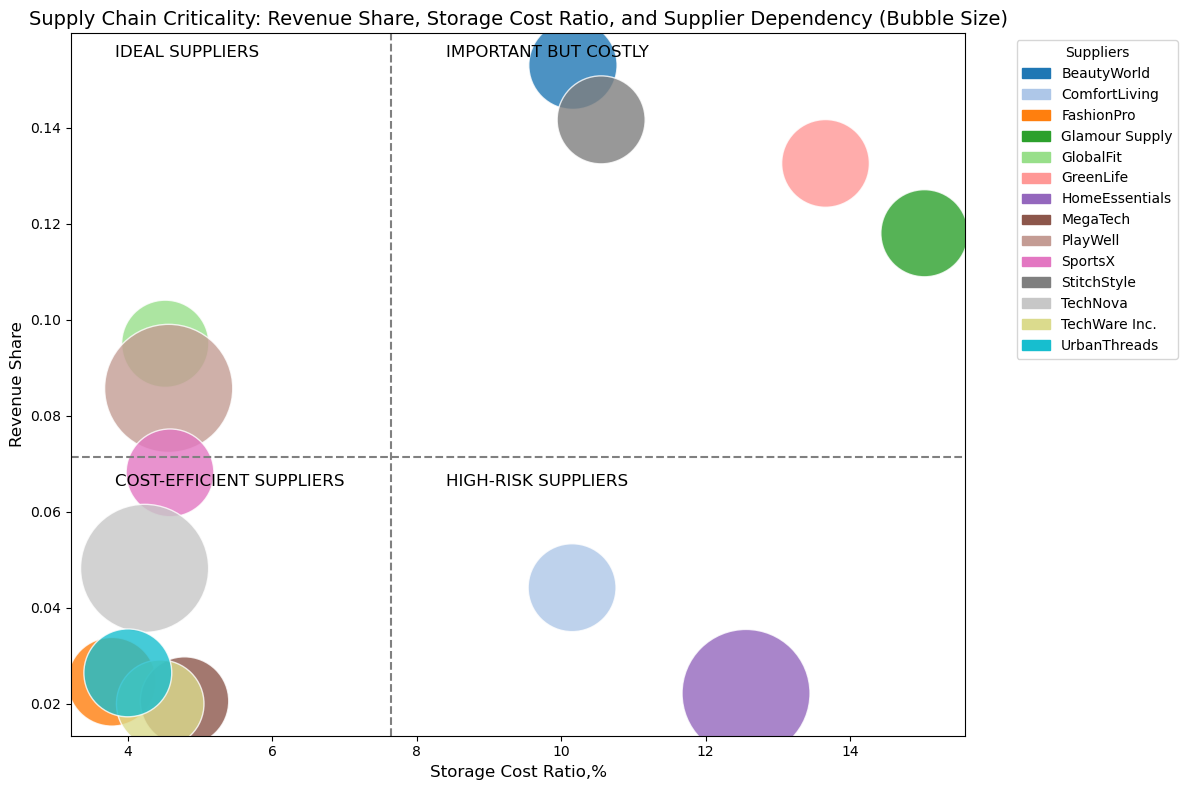

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps

# Load the dataset
file_path = "updated_dataset_with_features.csv"
df = pd.read_csv(file_path)

# Clean column names for easier access
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Drop the 'unnamed:_0' column, which is typically an index column
df = df.drop(columns=['unnamed:_0'], errors='ignore')

# Calculate Revenue Share for each supplier
df['revenue_share'] = df.groupby('supplier')['total_revenue'].transform('sum') / df['total_revenue'].sum()

# Remove duplicates and group by supplier to calculate the averages
df_grouped = df.groupby('supplier')[['storage_cost_ratio_revenue', 'revenue_share', 'supplier_dependency']].mean().reset_index()

# Check if the data is available
if df_grouped.empty:
    print("No data available after grouping by supplier. Please check the data.")
else:
    # Create a consistent colormap for suppliers
    colormap = colormaps.get_cmap('tab20')  # Use a colormap with distinct colors
    supplier_colors = {supplier: colormap(idx / len(df_grouped['supplier'].unique()))
                       for idx, supplier in enumerate(df_grouped['supplier'].unique())}
    df_grouped['color'] = df_grouped['supplier'].map(supplier_colors)

    # Calculate average values for both axes
    avg_storage_cost_ratio = df_grouped['storage_cost_ratio_revenue'].mean()
    avg_revenue_share = df_grouped['revenue_share'].mean()

    # Plot the bubble chart
    plt.figure(figsize=(12, 8))

    # Plot the bubble chart using Matplotlib
    scatter = plt.scatter(
        x=df_grouped['storage_cost_ratio_revenue'],
        y=df_grouped['revenue_share'],
        s=df_grouped['supplier_dependency']*100,  # Bubble size (scaled by 100 for visibility)
        alpha=0.8,  # Adjust the transparency of the bubbles
        c=[supplier_colors[supplier] for supplier in df_grouped['supplier']],  # Color bubbles
        edgecolors='w',  # Edge color for the bubbles
    )

    # Add vertical and horizontal lines to create quadrants
    plt.axvline(x=avg_storage_cost_ratio, color='gray', linestyle='--')
    plt.axhline(y=avg_revenue_share, color='gray', linestyle='--')

    # Adjust label positions to be at the top border of each quadrant
    plt.text(
        avg_storage_cost_ratio / 2,
        avg_revenue_share * 2.2,
        'IDEAL SUPPLIERS',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio * 1.1,
        avg_revenue_share * 2.2,
        'IMPORTANT BUT COSTLY',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio / 2,
        avg_revenue_share * 0.95,
        'COST-EFFICIENT SUPPLIERS',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio * 1.1,
        avg_revenue_share * 0.95,
        'HIGH-RISK SUPPLIERS',
        fontsize=12, color='black', ha='left', va='top'
    )

    # Add labels and title
    plt.title('Supply Chain Criticality: Revenue Share, Storage Cost Ratio, and Supplier Dependency (Bubble Size)', fontsize=14)
    plt.xlabel('Storage Cost Ratio,%', fontsize=12)
    plt.ylabel('Revenue Share', fontsize=12)

    # Create a legend for the color code based on suppliers
    handles = [mpatches.Patch(color=supplier_colors[supplier], label=supplier) for supplier in supplier_colors]
    plt.legend(handles=handles, title='Suppliers', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

**Higher Left Quadrant (GlobalFit, PlayWell):**

1) Characteristics: High Revenue Share and low Storage Cost Ratio. These suppliers contribute significantly to revenue while maintaining cost efficiency.
2) Supplier Dependency (Bubble Size): PlayWell has the highest dependency (85.06), making it a highly critical supplier. GlobalFit has lower dependency (39.37) but is still strategically important due to high revenue and cost efficiency.
3) Recommendation: Focus on strengthening relationships with PlayWell and GlobalFit.

**Higher Right Quadrant (BeautyWorld, StitchStyle, GreenLife, Glamour Supply):**

1) Characteristics: High Revenue Share but high Storage Cost Ratio. These suppliers contribute well to revenue but are less cost-efficient.
2) Supplier Dependency (Bubble Size): Dependency ranges from 39.33 (Glamour Supply) to 40.37 (BeautyWorld).
3) Recommendation: Explore opportunities to optimize storage costs for these suppliers. Ensure that their contribution to revenue justifies the higher costs.

**Lower Left Quadrant (SportsX, TechNova, UrbanThreads, FashionPro, TechWare, MegaTech):**

1) Characteristics: Low Revenue Share and low Storage Cost Ratio. These suppliers are cost-efficient but contribute less to revenue.
2) Supplier Dependency (Bubble Size):T echNova (84.97) and TechWare Inc. (39.72) stand out with high and low dependencies, respectively.
3) Recommendations: Manage TechNova carefully as high dependency could pose a risk despite low revenue contribution. As for others, consider if their role in the supply chain is justified or if they could be replaced with higher-performing alternatives.

**Lower Right Quadrant (ComfortLiving, HomeEssentials):**

1) Characteristics: Low Revenue Share and high Storage Cost Ratio. These suppliers are neither cost-efficient nor significant revenue contributors.
2) Supplier Dependency (Bubble Size): HomeEssentials (84.86) has one of the highest dependency rates, whereas that of ComfortLiving (40.02) is moderate.
3) Recommendations: For HomeEssentials, reassess this supplier’s role due to its high dependency and poor performance. For ComfortLiving, explore replacement options or strategies to reduce costs.

### 3.10. Supply Risk Factor Analysis

In [ ]:
# Load the dataset
file_path = "updated_dataset_with_features.csv"
df = pd.read_csv(file_path)

# Ensure column names are consistent
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

# Step 1: Calculate SRF
# Formula: SRF = (Defect Rate + Storage Cost Ratio) × (1 + Supplier Dependency)
df['srf'] = (df['defect_rate'] + df['storage_cost_ratio_revenue']) * (1 + df['supplier_dependency'])

# Step 2: Handle potential NaN or inf values
df['srf'] = df['srf'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
df = df.dropna(subset=['srf'])  # Drop rows with NaN SRF if necessary

# Step 3: Calculate average SRF by supplier, round to 1 decimal, and sort in descending order
srf_summary = (
    df.groupby('supplier', as_index=False)['srf']
    .mean()
    .round(1)  # Round SRF to 1 decimal
    .sort_values(by='srf', ascending=False)
)

# Step 4: Add Normalized Index
# Normalize SRF values to a scale between 0 and 1
srf_summary['normalized_index'] = (
    (srf_summary['srf'] - srf_summary['srf'].min()) /
    (srf_summary['srf'].max() - srf_summary['srf'].min())
)

# Display the SRF summary with normalized index
print(srf_summary)

          supplier     srf  normalized_index
11        TechNova  1318.7          1.000000
8         PlayWell  1103.5          0.759714
6   HomeEssentials  1082.3          0.736043
10     StitchStyle   908.3          0.541760
13    UrbanThreads   900.4          0.532939
2       FashionPro   899.3          0.531711
0      BeautyWorld   890.5          0.521885
3   Glamour Supply   864.0          0.492296
5        GreenLife   662.1          0.266860
9          SportsX   593.8          0.190598
4        GlobalFit   520.4          0.108642
1    ComfortLiving   514.5          0.102054
7         MegaTech   449.0          0.028919
12   TechWare Inc.   423.1          0.000000


**Top-Risk Suppliers:**

1) TechNova (1318.7): This supplier has the highest risk score. Its combination of defective unit rates, high storage costs, and high dependency makes it a significant liability to operations. Immediate risk mitigation strategies are needed, such as quality improvement initiatives or contingency planning.
2) PlayWell (1103.5): another high-risk supplier with a notable dependency factor and operational inefficiencies. Prioritize strategies to reduce dependency or address quality and cost issues.
3) HomeEssentials (1082.3): High risk driven by poor performance in defect rates and costs, coupled with significant dependency. Evaluate whether their strategic role justifies the risk or if alternative suppliers can fill the gap.

**Moderate-Risk Suppliers (StitchStyle, UrbanThreads, FashionPro, BeautyWorld, Glamour Supply):**
These suppliers are moderately risky, with balanced contributions to defects, costs, and dependency. Monitor their performance closely and address specific areas of concern (e.g., reduce defect rates or renegotiate storage costs).

**Lower-Risk Suppliers (Others):** These suppliers pose a relatively low risk, with fewer issues related to quality and cost-efficiency. Dependency levels are manageable. Maintain current strategies but explore areas for further optimization.

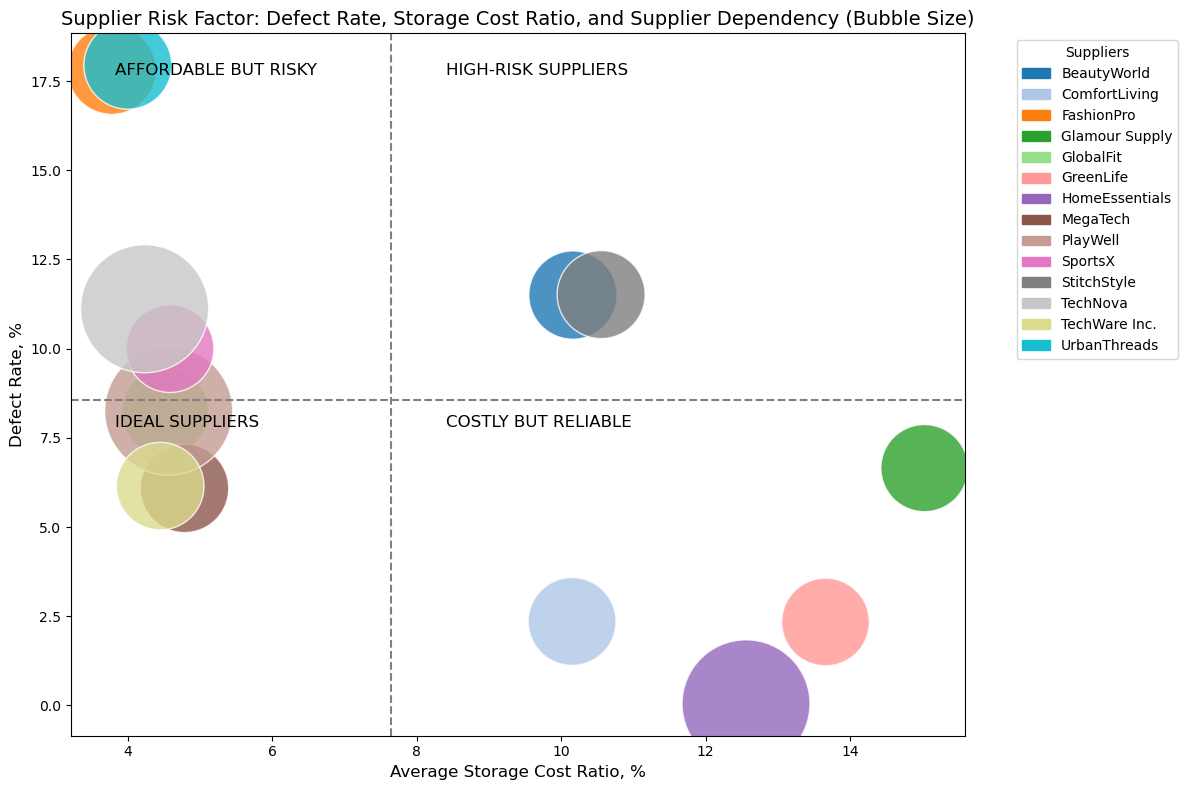

In [ ]:
# Drop the 'unnamed:_0' column, which is typically an index column
df = df.drop(columns=['unnamed:_0'], errors='ignore')

# Step 1: Calculate Revenue Share for each supplier
df['revenue_share'] = df.groupby('supplier')['total_revenue'].transform('sum') / df['total_revenue'].sum()

# Step 2: Remove duplicates and group by supplier to calculate the averages
df_grouped = df.groupby('supplier')[['storage_cost_ratio_revenue', 'defect_rate', 'supplier_dependency']].mean().reset_index()

# Step 3: Check if the data is available
if df_grouped.empty:
    print("No data available after grouping by supplier. Please check the data.")
else:
    # Step 4: Create a consistent colormap for suppliers
    colormap = colormaps.get_cmap('tab20')  # Use a colormap with distinct colors
    supplier_colors = {supplier: colormap(idx / len(df_grouped['supplier'].unique()))
                       for idx, supplier in enumerate(df_grouped['supplier'].unique())}
    df_grouped['color'] = df_grouped['supplier'].map(supplier_colors)

    # Calculate average values for both axes
    avg_storage_cost_ratio = df_grouped['storage_cost_ratio_revenue'].mean()
    avg_defect_rate = df_grouped['defect_rate'].mean()

    # Step 5: Plot the bubble chart
    plt.figure(figsize=(12, 8))

    # Plot the bubble chart using Matplotlib (with the correct axes)
    scatter = plt.scatter(
        x=df_grouped['storage_cost_ratio_revenue'],
        y=df_grouped['defect_rate'],
        s=df_grouped['supplier_dependency'] * 100,  # Bubble size (scaled by 100 for visibility)
        alpha=0.8,  # Adjust the transparency of the bubbles
        c=[supplier_colors[supplier] for supplier in df_grouped['supplier']],  # Color bubbles
        edgecolors='w',  # Edge color for the bubbles
    )

    # Add vertical and horizontal lines to create quadrants
    plt.axvline(x=avg_storage_cost_ratio, color='gray', linestyle='--')  # Vertical line for storage cost ratio
    plt.axhline(y=avg_defect_rate, color='gray', linestyle='--')  # Horizontal line for defect rate

    # Adjust label positions to be at the top border of each quadrant
    plt.text(
        avg_storage_cost_ratio / 2,
        avg_defect_rate * 2.1,  # Slightly above the average for top-left quadrant
        'AFFORDABLE BUT RISKY',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio * 1.1,
        avg_defect_rate * 2.1,  # Slightly above the average for top-right quadrant
        'HIGH-RISK SUPPLIERS',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio / 2,
        avg_defect_rate * 0.95,  # Slightly below the average for bottom-left quadrant
        'IDEAL SUPPLIERS',
        fontsize=12, color='black', ha='left', va='top'
    )
    plt.text(
        avg_storage_cost_ratio * 1.1,
        avg_defect_rate * 0.95,  # Slightly below the average for bottom-right quadrant
        'COSTLY BUT RELIABLE',
        fontsize=12, color='black', ha='left', va='top'
    )

    # Add labels and title with supplier dependency (bubble size) mentioned
    plt.title('Supplier Risk Factor: Defect Rate, Storage Cost Ratio, and Supplier Dependency (Bubble Size)', fontsize=14)
    plt.xlabel('Average Storage Cost Ratio, %', fontsize=12)
    plt.ylabel('Defect Rate, %', fontsize=12)

    # Create a legend for the color code based on suppliers
    handles = [mpatches.Patch(color=supplier_colors[supplier], label=supplier) for supplier in supplier_colors]
    plt.legend(handles=handles, title='Suppliers', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save and show the plot
    plt.tight_layout()
    plt.savefig('supplier_risk_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

**Higher Left Quadrant (UrbanThreads, FashionPro, TechNova, SportsX)**
1) Characteristics: These suppliers have high defect rates but manage to maintain low storage costs. The high defect rate is a significant concern and can impact product quality or customer satisfaction. However, their low storage costs reduce the overall cost burden.
2) Dependency is moderate, except for TechNova (84.98%)
3) Recommendations: Focus on improving quality while maintaining cost efficiency. Diversify if defect issues persist, especially for highly dependent suppliers like TechNova.

**Higher Right Quadrant (BeautyWorld, StitchStyle):**

1) Characteristics: These high-risk suppliers have both high defect rates and high storage costs, representing a dual burden and contributing to both quality issues and cost inefficiencies
2) Dependency levels are moderate (BeautyWorld: 40.37%, StitchStyle: 40.12%).
2) Recommendations: These suppliers require immediate action to renegotiate costs or improve quality. Monitor dependency closely to prevent over-reliance on high-risk suppliers.

**Lower Left Quadrant (MegaTech, TechWare, PlayWell, GlobalFit)**
1) Characteristics: Suppliers in this quadrant exhibit strong performance, with low defect rates and cost efficiency.
2) Dependency levels are moderate, except for PlayWell (85.06%)
3) Recommendations: Strengthen relationships with these suppliers while managing dependency risk for PlayWell.

**Lower Right Quadrant (ComfortLiving, HomeEssential, GreenLife, Glamour Supply)**
1) Characteristics: These suppliers maintain good quality (low defect rates) but at a high storage cost. These suppliers may still add value due to their quality, but high storage costs could strain budgets.
2) Dependency level is high for HomeEssentials (84.86%) and moderate for others.
3) Recommendations: Negotiate better terms to lower storage costs. Maintain quality but reduce reliance on highly dependent suppliers like HomeEssentials.

## 4. ML Proposal: Predicting Supplier Performance

### 4.1. Introduction and Problem Statement

<span style="font-size: 16px;"> In supply chain management, understanding supplier performance is crucial for mitigating risks and ensuring operational efficiency. A key challenge faced by businesses is managing suppliers that may not consistently meet quality standards, leading to defective products and operational disruptions. In particular, the Clothing Products category has experienced a defect rate of 18% of total stock, resulting in a sales loss exceeding 12% of average monthly revenue (see Section 3.8). At the same time, the average supplier dependency in this product category reaches 50%, with one of the leading suppliers featuring a supplier dependency ratio of 85%. This highlights the need for a predictive tool that not only identifies defective items but also evaluates overall supplier reliability and performance, especially in cases where high dependency may pose significant risks.

<span style="font-size: 16px;"> This study proposes the development of a **classification model** aimed at predicting supplier performance across three categories: **Top Performer**, **Average Performer**, and **Underperformer**. By analyzing historical data on defect rates, supplier dependency, sales, revenue, and storage costs, the model provides businesses with a reliable method for categorizing suppliers, enabling proactive management strategies to address at-risk suppliers.

<span style="font-size: 16px;"> **Justification:** The choice of using a classification model, particularly a **Random Forest Classifier**, is driven by the following factors:

1) **Multi-dimensional Supplier Performance:** Predicting overall supplier performance requires more than just forecasting revenue contribution or defect rates. A classification model allows us to incorporate a variety of key metrics (defect rate, supplier dependency, sales, and costs) that together determine the supplier's reliability and potential risks.
2) **Business Impact:** Supplier performance directly impacts a company’s bottom line. By categorizing suppliers into performance groups, we can identify which suppliers are at risk (Underperformers) and which are excelling (Top Performers). This classification enables targeted interventions—whether renegotiations, quality audits, or finding alternative suppliers.
3) **Interpretability:** The Random Forest Classifier provides clear and interpretable results, which makes it easier to act on the predictions. The model assigns suppliers to easily understandable categories, ensuring decision-makers can take timely and informed actions.
4) **Practical Applicability:** The features used in the model, such as defect rate, sales data, and supplier dependency, are readily available. Thus, the model can be implemented without significant additional data collection or infrastructure changes.

<span style="font-size: 16px;"> **Benefits:**

1) **Proactive Risk Mitigation:** By categorizing suppliers into performance groups, the model allows businesses to take proactive actions. For example, identifying Underperformers can trigger a review of the supplier’s quality controls, renegotiation of terms, or sourcing alternatives before the problem escalates.
2) **Optimized Supplier Relationships:** The model helps optimize supplier relationships by identifying high-performing suppliers that could be rewarded or given preferential treatment. Top Performers can be nurtured to ensure their continued support, while Average Suppliers can be monitored more closely.
3) **Increased Operational Efficiency:** By addressing suppliers based on their performance category, businesses can allocate resources more efficiently. This can help reduce unnecessary audits or checks on suppliers performing well, freeing up resources for more critical tasks.
4) **Data-Driven Decision-Making:** The model turns raw data (e.g., defect rates, sales) into actionable insights. It helps decision-makers move from reactive, subjective supplier management to a data-driven, objective approach, improving supply chain resilience.
5) **Scalable Solution:** The model can be applied across various product categories and suppliers, providing a scalable solution to managing supplier performance. As more data becomes available, the model can evolve and adapt to new patterns of supplier behavior.

### 4.2. EDA and Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv("updated_dataset_with_features.csv")

# Preview the dataset
data.head()

,unnamed:_0,product_id,product_name,category,supplier,month,unit_price,stock_quantity,monthly_sales,monthly_revenue,...,revenue_check_rounded,monthly_revenue_rounded,cost,profit_margin,total_storage_cost,storage_cost_ratio_revenue,defect_rate,defect_associated_loss,total_revenue,ratio
0,0,P00071,Kitchen Utensils,Home Goods,GreenLife,2023-01-03,170.37,31,20,3407.4,...,3407.4,3407.4,5292.78,-55.331925,350.61,10.289664,0.0,0.0,3407.4,0.0
1,1,P00071,Kitchen Utensils,Home Goods,GreenLife,2023-01-04,170.37,31,20,3407.4,...,3407.4,3407.4,5292.78,-55.331925,350.61,10.289664,0.0,0.0,3407.4,0.0
2,2,P00071,Kitchen Utensils,Home Goods,GreenLife,2023-01-05,170.37,31,20,3407.4,...,3407.4,3407.4,5292.78,-55.331925,350.61,10.289664,0.0,0.0,3407.4,0.0
3,3,P00071,Kitchen Utensils,Home Goods,GreenLife,2023-01-06,170.37,31,20,3407.4,...,3407.4,3407.4,5292.78,-55.331925,350.61,10.289664,0.0,0.0,3407.4,0.0
4,4,P00071,Kitchen Utensils,Home Goods,GreenLife,2023-01-07,170.37,31,20,3407.4,...,3407.4,3407.4,5292.78,-55.331925,350.61,10.289664,0.0,0.0,3407.4,0.0


In [ ]:
# Define the columns required for the analysis
required_columns = [
    'monthly_sales', 'unit_price', 'storage_cost_per_unit',
    'supplier_dependency', 'monthly_revenue', 'defect_rate',
    'supplier'
]

# Filter the dataset to only include required columns
data = data[required_columns]

# Display the filtered data
data.head()

,monthly_sales,unit_price,storage_cost_per_unit,supplier_dependency,monthly_revenue,defect_rate,supplier
0,20,170.37,11.31,15,3407.4,0.0,GreenLife
1,20,170.37,11.31,15,3407.4,0.0,GreenLife
2,20,170.37,11.31,15,3407.4,0.0,GreenLife
3,20,170.37,11.31,15,3407.4,0.0,GreenLife
4,20,170.37,11.31,15,3407.4,0.0,GreenLife


In [ ]:
# Handle missing values
numeric_columns = data.select_dtypes(include=np.number).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Check if there are any remaining missing values
data.isnull().sum()

monthly_sales            0
unit_price               0
storage_cost_per_unit    0
supplier_dependency      0
monthly_revenue          0
defect_rate              0
supplier                 0
dtype: int64

### 4.3. Feature Engineering

In [ ]:
# Feature Engineering: Normalize features
features = ['monthly_sales', 'unit_price', 'storage_cost_per_unit',
            'supplier_dependency', 'monthly_revenue', 'defect_rate']

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Display the normalized features
data[features].head()

,monthly_sales,unit_price,storage_cost_per_unit,supplier_dependency,monthly_revenue,defect_rate
0,-0.556545,-0.392606,0.198522,-1.447337,-0.516648,-1.113305
1,-0.556545,-0.392606,0.198522,-1.447337,-0.516648,-1.113305
2,-0.556545,-0.392606,0.198522,-1.447337,-0.516648,-1.113305
3,-0.556545,-0.392606,0.198522,-1.447337,-0.516648,-1.113305
4,-0.556545,-0.392606,0.198522,-1.447337,-0.516648,-1.113305


In [ ]:
# Define the function to categorize suppliers
def categorize_supplier(row):
    if row['defect_rate'] < 0.5 and row['supplier_dependency'] < 0.5:
        return 'Top Performer'
    elif row['defect_rate'] > 0.5 and row['supplier_dependency'] > 0.5:
        return 'Underperformer'
    else:
        return 'Average'

# Apply the categorization function
data['performance_category'] = data.apply(categorize_supplier, axis=1)

# Display the new column
data[['defect_rate', 'supplier_dependency', 'performance_category']].head()

,defect_rate,supplier_dependency,performance_category
0,-1.113305,-1.447337,Top Performer
1,-1.113305,-1.447337,Top Performer
2,-1.113305,-1.447337,Top Performer
3,-1.113305,-1.447337,Top Performer
4,-1.113305,-1.447337,Top Performer


In [ ]:
# Convert the target variable to numeric labels
data['performance_category'] = data['performance_category'].map({
    'Top Performer': 0, 'Average': 1, 'Underperformer': 2
})

# Check the encoded values
data['performance_category'].value_counts()

performance_category
0    255461
1    221917
2     47742
Name: count, dtype: int64

### 4.3. Model Training

In [ ]:
# Split the data into features and target variable
X = data[features]
y = data['performance_category']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((420096, 6), (105024, 6), (420096,), (105024,))

In [ ]:
# Build a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### 4.4. Model Evaluation and Cross-Validation

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51155
           1       1.00      1.00      1.00     44205
           2       1.00      1.00      1.00      9664

    accuracy                           1.00    105024
   macro avg       1.00      1.00      1.00    105024
weighted avg       1.00      1.00      1.00    105024


Confusion Matrix:
[[51155     0     0]
 [    0 44205     0]
 [    0     0  9664]]


In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

# Display cross-validation results
print("\nCross-validation scores:", cv_scores)
print("Mean accuracy from cross-validation:", cv_scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy from cross-validation: 1.0


The classification model achieved seemingly perfect results. However, the "perfect" output clearly suggests that the model is overfitting. A perfect classification report with a confusion matrix that has no misclassifications, combined with cross-validation scores of 1.0, is highly unusual.

The key problem here is that the dataset used for training and testing appears to be highly structured or synthetic, lacking the variability typically found in real-world data (See Section 2 of this document). If the labels and features are overly correlated or derived from simple rules, the model can easily memorize the patterns, leading to inflated results. The model may have overfit the data due to its simplicity or lack of diversity, resulting in exceptional performance on the given dataset but limited generalizability.

**Next Steps:**

1) The issue lies in the dataset rather than the model's architecture or fitness. This means alternative algorithms or hyperparameter tuning are unlikely to yield significantly different results, as the underlying data already guarantees perfect classification.
2) To validate the model's robustness, it should be tested on a real-world dataset or one with greater variability and noise.
3) If synthetic data must be used, it should be ensured that it mimics real-world variability, including overlapping class features, noise, and inconsistencies.

### 4.4. Conclusions: Model's Real World Application

 <span style="font-size: 16px;"> The model can absolutely serve as a showcase for addressing real-world supply management problems, even though its performance metrics are inflated due to the synthetic nature of the dataset:

1) The features used in the model—such as defect rates, supplier dependency, and storage costs—are critical metrics in supply management. These metrics align closely with the challenges faced in managing supplier relationships, maintaining inventory quality, and optimizing costs. Therefore, the model's structure reflects practical considerations, even if the dataset is synthetic.

2) The classification of suppliers into "Top Performers," "Average Performers", and "Underperformers" is a highly interpretable and actionable output. This mirrors real-world supply chain management scenarios where companies must categorize suppliers based on performance and take tailored actions (e.g., quality audits, renegotiations, or reallocation of orders).

3) Even if the dataset is synthetic, the approach showcases how the company can use machine learning to predict supplier risks proactively.

4) The methodology — data preprocessing, feature engineering, classification, and evaluation — provides a framework that can be adapted to real-world datasets. The steps can serve as a blueprint for building more robust models using real-world data.